## **PREPARACIÓN DEL NOTEBOOK**

In [33]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


%matplotlib inline

## **CONJUNTO DE DATOS**

### **LECTURA DEL DATASET**

In [34]:
df = pd.read_csv("https://raw.githubusercontent.com/JavierBurgos-web/PROYECTO_ANALITICA_2da_entrega/main/FIFA_22.csv", sep=";", encoding="ISO-8859-1")
df.head(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [35]:
#Información general de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(18), int64(44), object(48)
memory usage: 16.1+ MB


### **PRE-SELECCIÓN DE VARIABLES**

**ELIMINACIÓN**

In [36]:
#Identificación de variables con mas de un 80% de valores nulos
df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

value_eur                     0.384635
wage_eur                      0.317064
club_team_id                  0.317064
club_name                     0.317064
league_name                   0.317064
league_level                  0.317064
club_position                 0.317064
club_jersey_number            0.317064
club_loaned_from             94.272052
club_joined                   6.045013
club_contract_valid_until     0.317064
nation_team_id               96.054889
nation_position              96.054889
nation_jersey_number         96.054889
release_clause_eur            6.112584
player_tags                  92.510006
player_traits                51.151307
pace                         11.081657
shooting                     11.081657
passing                      11.081657
dribbling                    11.081657
defending                    11.081657
physic                       11.081657
goalkeeping_speed            88.918343
lw                            1.694475
rw                       

In [37]:
#Eliminación de variables con mas de un 80% de valores nulos
df = df.drop(columns = ['nation_logo_url','player_tags','player_traits',
                        'nation_jersey_number','nation_position','nation_team_id','club_loaned_from',
                       'goalkeeping_speed','club_name','short_name','club_name','league_name','player_positions'])

#Eliminacion de variables que no aportan al modelo
df = df.drop(columns = ['player_url','long_name','nationality_id',
                        'player_face_url', 'club_logo_url','club_flag_url',
                        'nation_flag_url','body_type', 'real_face',
                        'sofifa_id','dob','club_jersey_number',
                        'club_team_id','league_level','potential',
                        'club_joined', 'club_contract_valid_until','nationality_name',
                        'work_rate',
                        'gk','rb','rcb','cb','lcb',
                        'lb','rwb','rdm','cdm', 'ldm',
                        'lwb', 'rm', 'rcm','cm','lcm',
                        'lm','ram','cam','lam','rf','cf',
                        'ls','st','rs','lf', 'rw', 'lw'])

**IMPUTACIÓN**

In [38]:
# Conteo de nulos en las variables que los contienen
df.isnull().sum()[df.isnull().sum() != 0]

value_eur               74
wage_eur                61
club_position           61
release_clause_eur    1176
pace                  2132
shooting              2132
passing               2132
dribbling             2132
defending             2132
physic                2132
dtype: int64

In [39]:
##tratamiento para nulos
median_physic = df['physic'].median()
median_defending = df['defending'].median()
median_dribbling = df['dribbling'].median()
median_passing = df['passing'].median()
median_shooting = df['shooting'].median()
median_pace = df['pace'].median()
median_release_clause_eur = df['release_clause_eur'].median()
median_wage_eur = df['wage_eur'].median()
median_value_eur  = df['value_eur'].median()
mode_club_position = df['club_position'].mode().iloc[0]

df['physic'].fillna(median_physic, inplace=True)
df['defending'].fillna(median_defending, inplace=True)
df['dribbling'].fillna(median_dribbling, inplace=True)
df['passing'].fillna(median_passing, inplace=True)
df['shooting'].fillna(median_shooting, inplace=True)
df['pace'].fillna(median_pace, inplace=True)
df['release_clause_eur'].fillna(median_release_clause_eur, inplace=True)
df['wage_eur'].fillna(median_wage_eur, inplace=True)
df['value_eur'].fillna(median_value_eur, inplace=True)
df['club_position'].fillna(mode_club_position, inplace=True)

In [40]:
# Verificando inputación de nulos
df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

### **ANÁLISIS EXPLORATORIO**

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,19239.0,6.577218e+01,6.880232e+00,47.0,61.0,66.0,70.0,93.0
value_eur,19239.0,2.843238e+06,7.599929e+06,9000.0,475000.0,975000.0,2000000.0,194000000.0
wage_eur,19239.0,8.998908e+03,1.944223e+04,500.0,1000.0,3000.0,8000.0,350000.0
age,19239.0,2.521082e+01,4.748235e+00,16.0,21.0,25.0,29.0,54.0
height_cm,19239.0,1.812997e+02,6.863179e+00,155.0,176.0,181.0,186.0,206.0
weight_kg,19239.0,7.494303e+01,7.069434e+00,49.0,70.0,75.0,80.0,110.0
weak_foot,19239.0,2.946151e+00,6.715605e-01,1.0,3.0,3.0,3.0,5.0
skill_moves,19239.0,2.352461e+00,7.676590e-01,1.0,2.0,2.0,3.0,5.0
international_reputation,19239.0,1.094184e+00,3.710982e-01,1.0,1.0,1.0,1.0,5.0
release_clause_eur,19239.0,5.143353e+06,1.451247e+07,16000.0,845000.0,1600000.0,3400000.0,373500000.0


<Axes: >

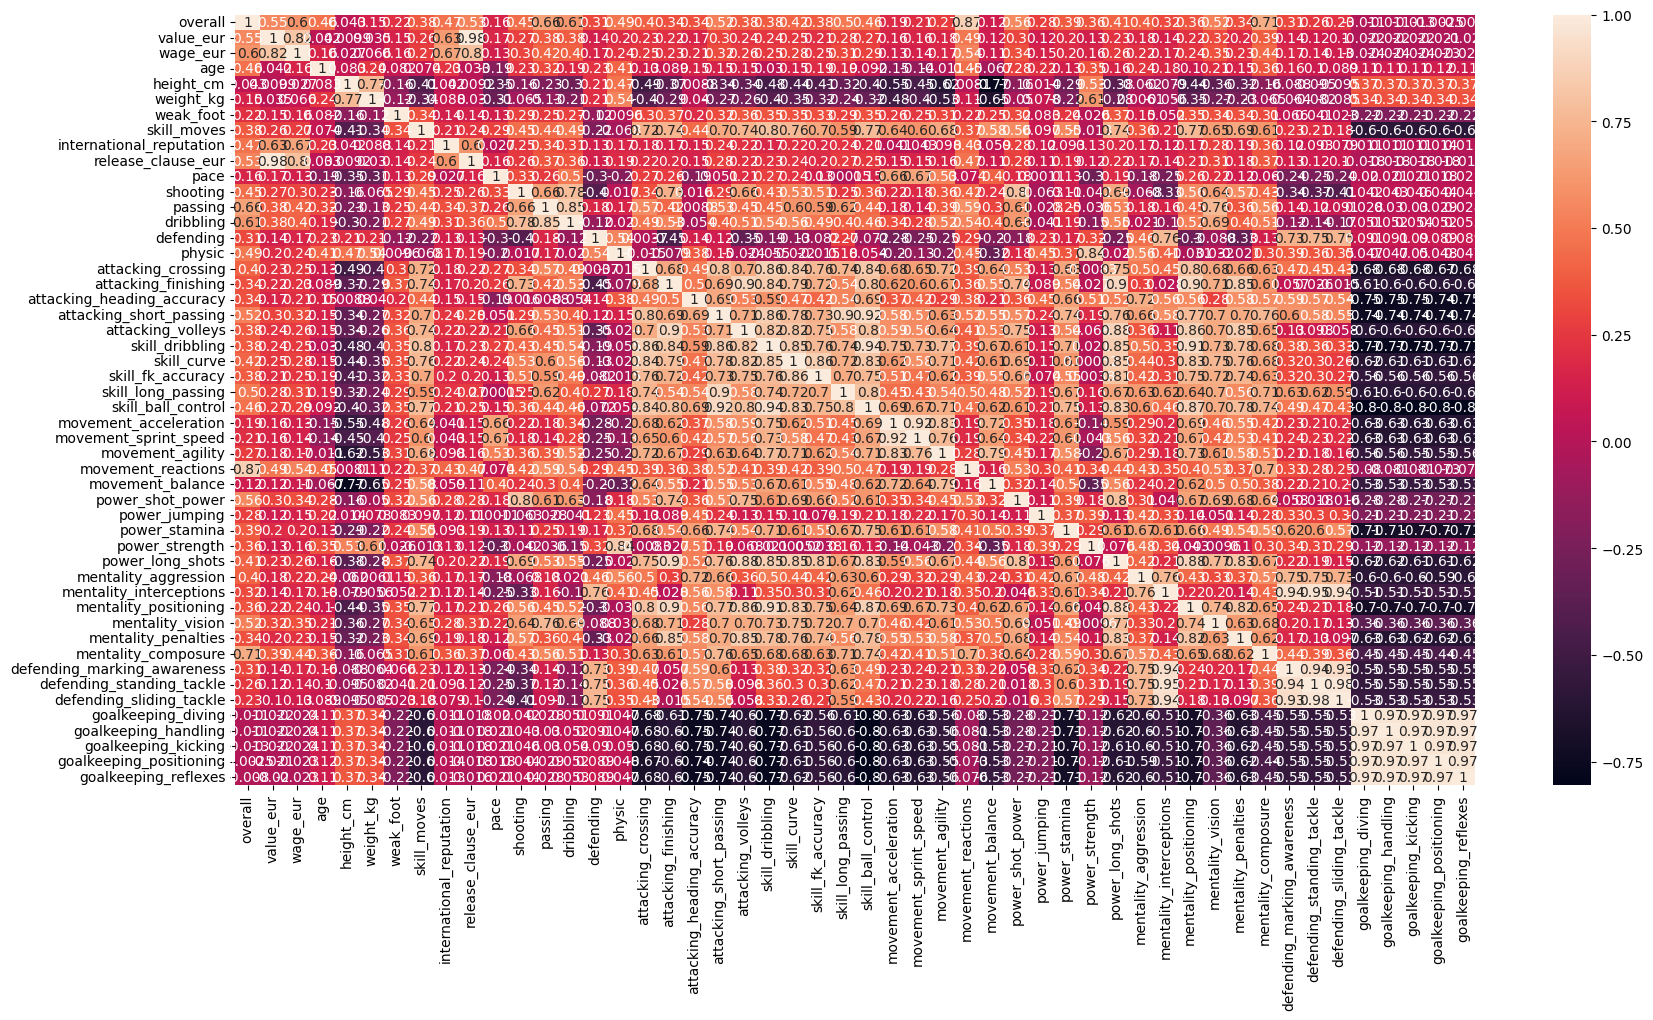

In [42]:
# Obtener las columnas de tipo numérico
df_numeric = df.select_dtypes(include=['number', 'float', 'int'])

# Generar la matriz de correlación
corr = df_numeric.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True)

In [43]:
# Categorias de la variable 'club_position'
df['club_position'].value_counts()

club_position
SUB    8360
RES    3168
RCB     701
GK      701
LCB     701
RB      515
LB      515
ST      476
RCM     470
LCM     470
LM      410
RM      410
CAM     292
LDM     223
RDM     223
LS      223
RS      223
CB      186
RW      185
LW      185
CDM     168
RWB     116
LWB     116
CM       83
RF       35
LF       35
LAM      21
RAM      21
CF        7
Name: count, dtype: int64

In [44]:
# Se eliminan las filas asociadas a las categorias 'RES' y 'SUB' puesto que contenian información  que ya esta en las otras.
df = df.query('club_position != "RES" and club_position != "SUB"')

In [45]:
### como se puede observar no hay nulos en las habilidades del jugador como portero, entonces se suman las 3 en un solo valor
# Promedios de habilidades de portero (goalkeeping)
df['goalkeeping1'] = (df['goalkeeping_reflexes'] + df['goalkeeping_positioning'] + df['goalkeeping_kicking'] + df['goalkeeping_handling'] + df['goalkeeping_diving']) / 5
# Promedio de habilidades de defensa (defending)
df['defending1'] = (df['defending_sliding_tackle'] + df['defending_standing_tackle'] + df['defending_marking_awareness']) / 3
# Promedio de habilidades de delantero (attacking)
df['attacking1'] = (df['attacking_crossing'] + df['attacking_finishing'] + df['attacking_heading_accuracy'] + df['attacking_short_passing'] + df['attacking_volleys']) / 5
# Promedio de habilidades de habilidades (skills)
df['skills1'] = (df['skill_ball_control'] + df['skill_long_passing'] + df['skill_fk_accuracy'] + df['skill_curve'] + df['skill_dribbling'] + df['skill_moves']) / 6
# Promedio de habilidades de mentalidad (mentality)
df['mentality1'] = (df['mentality_composure'] + df['mentality_penalties'] + df['mentality_vision'] + df['mentality_positioning'] + df['mentality_interceptions'] + df['mentality_aggression']) / 6
# Promedio de habilidades de movimiento (movement)
df['movement1'] = (df['movement_acceleration'] + df['movement_sprint_speed'] + df['movement_agility'] + df['movement_reactions'] + df['movement_balance']) / 5
# Promedio de habilidades de poder (power)
df['power'] = (df['power_shot_power'] + df['power_jumping'] + df['power_stamina'] + df['power_strength'] + df['power_long_shots']) / 5


# Reasignación de categorias
# 0 -> Mediocampista
# 1 -> Defensa
# 2 -> Portero
# 3 -> Delantero
df['club_position'] = df['club_position'].replace('CAM', '0') 
df['club_position'] = df['club_position'].replace('LDM', '0')
df['club_position'] = df['club_position'].replace('CB', '1') 
df['club_position'] = df['club_position'].replace('CDM', '0')
df['club_position'] = df['club_position'].replace('CF', '0')
df['club_position'] = df['club_position'].replace('CM', '0')
df['club_position'] = df['club_position'].replace('GK', '2')
df['club_position'] = df['club_position'].replace('LAM', '0')
df['club_position'] = df['club_position'].replace('LB', '1')
df['club_position'] = df['club_position'].replace('LCB', '1')
df['club_position'] = df['club_position'].replace('LCM', '0')
df['club_position'] = df['club_position'].replace('LF', '3') 
df['club_position'] = df['club_position'].replace('LM', '0')
df['club_position'] = df['club_position'].replace('LS', '3')
df['club_position'] = df['club_position'].replace('LW', '3')


df['club_position'] = df['club_position'].replace('LWB', '1')
df['club_position'] = df['club_position'].replace('RAM', '0')
df['club_position'] = df['club_position'].replace('RB', '1')
df['club_position'] = df['club_position'].replace('RCB', '1')
df['club_position'] = df['club_position'].replace('RCM', '0')
df['club_position'] = df['club_position'].replace('RDM', '0')
df['club_position'] = df['club_position'].replace('RF', '3')
df['club_position'] = df['club_position'].replace('RM', '0')
df['club_position'] = df['club_position'].replace('RS', '3')
df['club_position'] = df['club_position'].replace('RW', '3')
df['club_position'] = df['club_position'].replace('RWB', '1')
df['club_position'] = df['club_position'].replace('ST', '3')

In [46]:
# Categorias de la variable 'club_position'
df['club_position'].value_counts()

club_position
1    2850
0    2798
3    1362
2     701
Name: count, dtype: int64

In [47]:
df = df.drop(columns = ['goalkeeping_reflexes','goalkeeping_positioning','goalkeeping_kicking','goalkeeping_handling','goalkeeping_diving',
                        'defending_sliding_tackle','defending_standing_tackle','defending_marking_awareness',
                        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy','attacking_short_passing','attacking_volleys',
                        'skill_ball_control','skill_long_passing','skill_fk_accuracy','skill_curve','skill_dribbling','skill_moves',
                        'mentality_composure','mentality_penalties','mentality_vision','mentality_positioning','mentality_interceptions','mentality_aggression',
                        'movement_balance','movement_reactions','movement_agility','movement_sprint_speed','movement_acceleration',
                        'power_long_shots','power_strength','power_stamina','power_jumping','power_shot_power'])

In [48]:
# Eliminación de columna altamente correlacionada y con valores NaN
df.drop(['goalkeeping1'], axis=1, inplace=True)


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

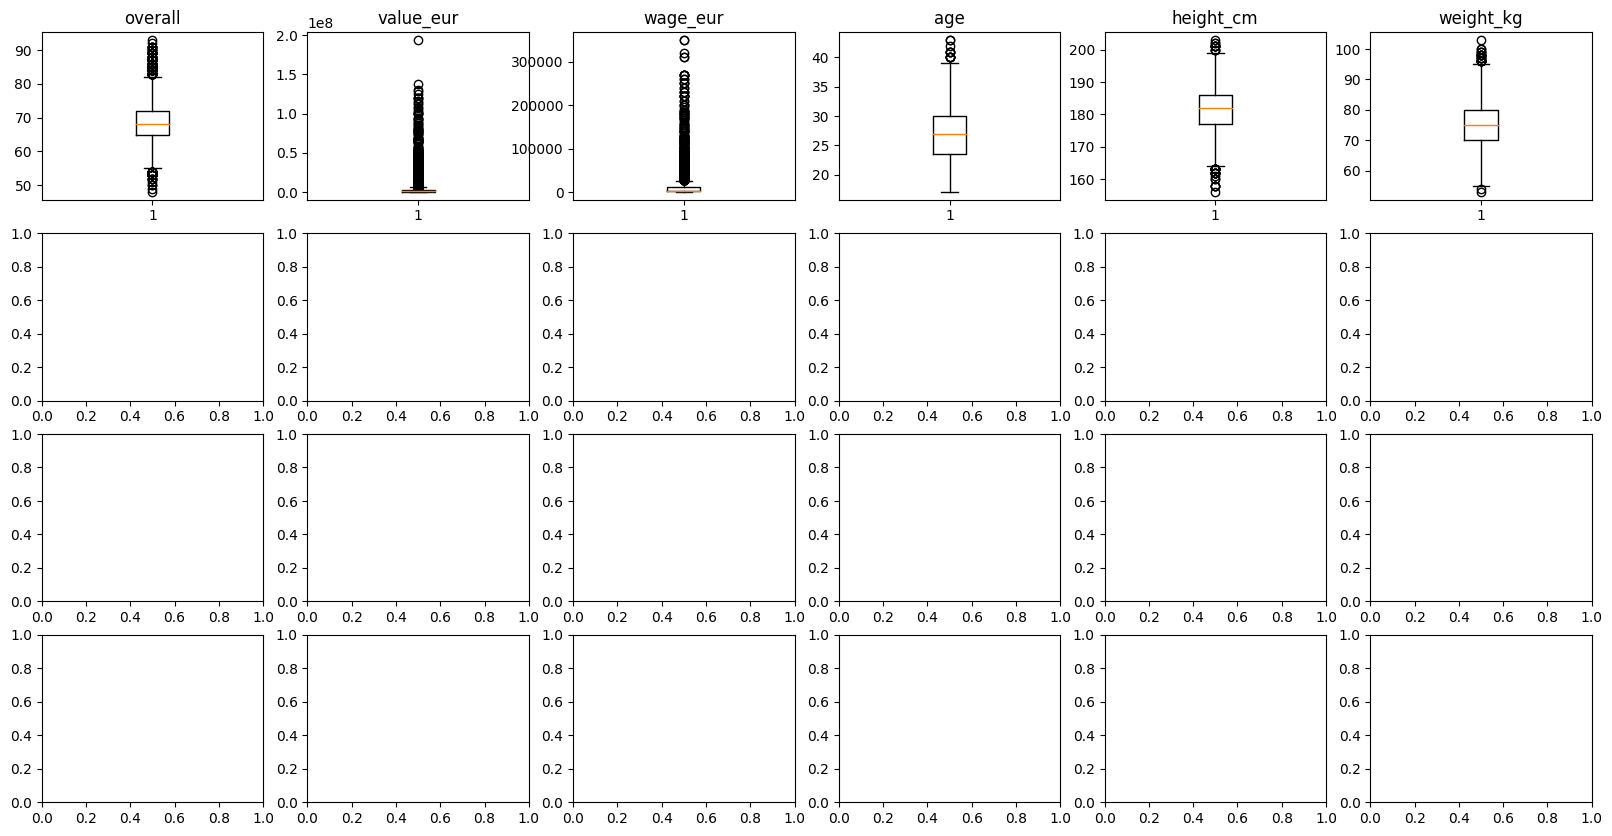

In [49]:
# Obtener las columnas del DataFrame, excluyendo 'club_position'
cols = df.columns.drop('club_position')

# Crear una figura y un eje
fig, ax = plt.subplots(4, 6, figsize=(20, 10))

# Crear boxplots para cada variable
for i, col in enumerate(cols):
    data = df[col]
    ax[i // 6, i % 6].boxplot(data)
    ax[i // 6, i % 6].set_title(col)

# Mostrar la figura
plt.show()

In [ ]:
# Se elimina variables compuestas en su mayoria por datos atipicos
df = df.drop(columns = ['value_eur', 
                        'wage_eur', 
                        'weak_foot',
                        'international_reputation',
                        'release_clause_eur', 
                        'preferred_foot'])

KeyError: "['value_eur', 'wage_eur', 'weak_foot', 'international_reputation', 'release_clause_eur'] not found in axis"

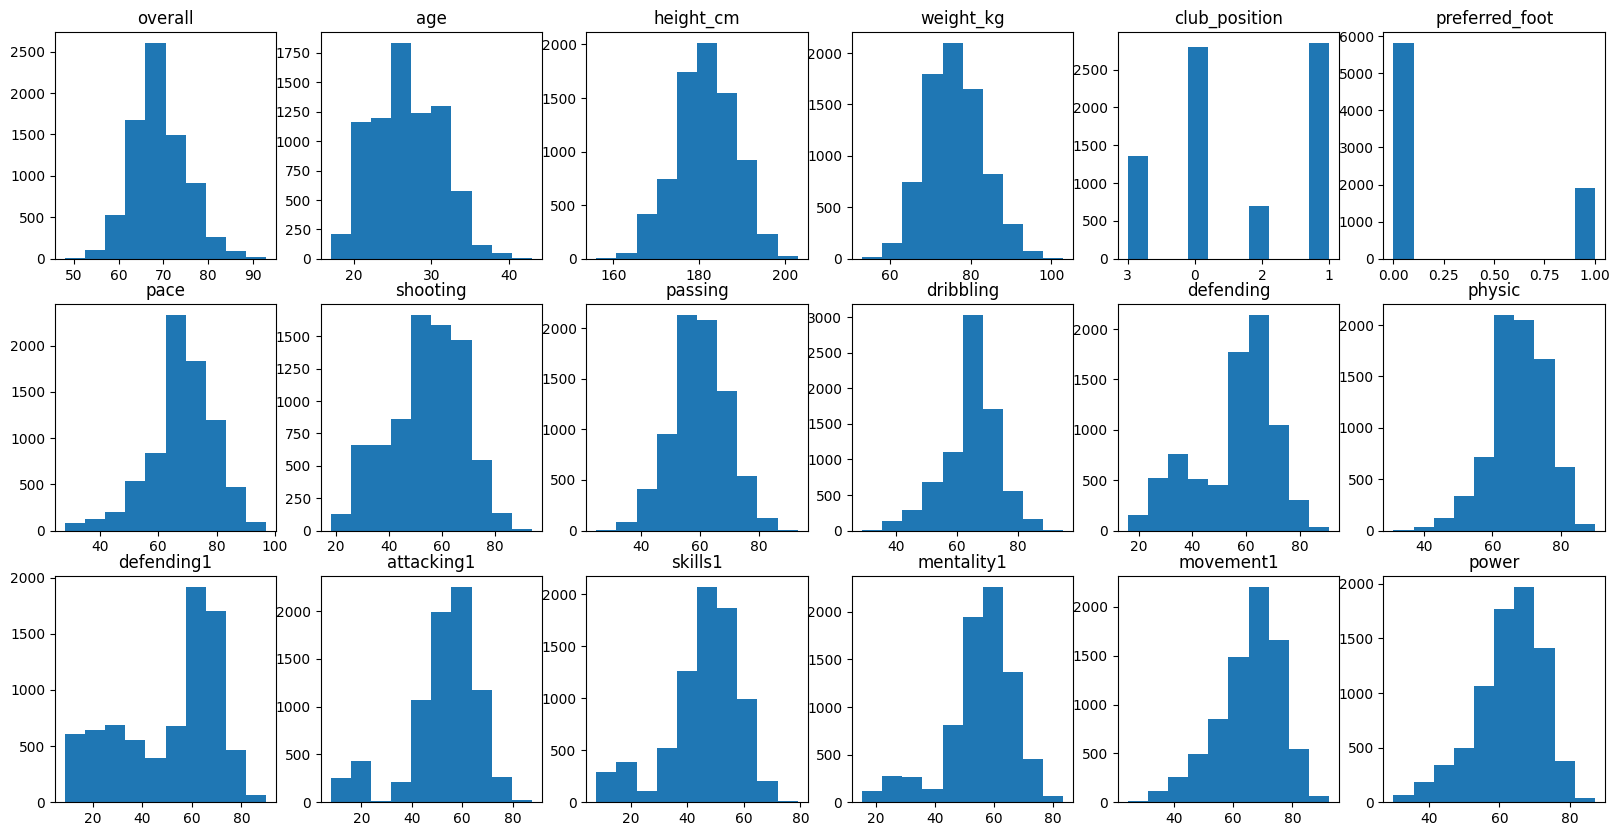

In [ ]:
# Obtener las columnas del DataFrame
cols = df.columns

# Crear una figura y un eje
fig, ax = plt.subplots(3, 6, figsize=(20, 10))

# Crear gráficos de distribución para cada variable
for i, col in enumerate(cols):
    data = df[col]
    ax[i // 6, i % 6].hist(data)
    ax[i // 6, i % 6].set_title(col)

# Mostrar la figura
plt.show()

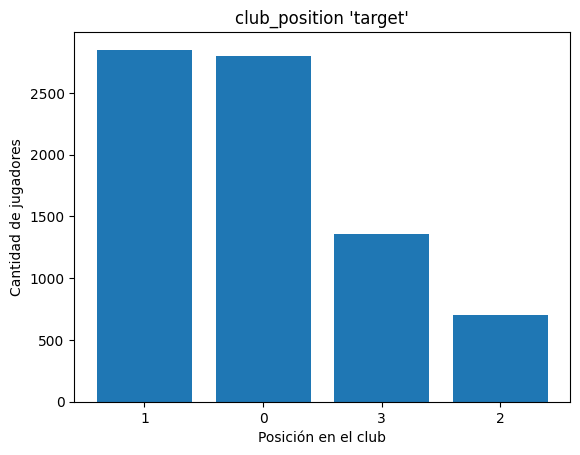

In [ ]:
# Distribución de 'target'
counts = df['club_position'].value_counts()

# Creamos el gráfico de barras
plt.bar(counts.index, counts)
plt.title("club_position 'target'")
plt.xlabel('Posición en el club')
plt.ylabel('Cantidad de jugadores')
plt.show()

### **EXPORTACIÓN DEL DATASET**

In [32]:
df.to_csv('dataset_limpio.csv', index=False)